# 음성데이터 조작해보기

*데이터 불러오기*

In [1]:
import librosa
import pandas as pd
import numpy as np

In [2]:
example_audio_path = '/content/drive/Othercomputers/내 컴퓨터/Scream_Detection/example/꿩+klankbeeld.wav'   # 소리 데이터
example_label_path = '/content/drive/Othercomputers/내 컴퓨터/Scream_Detection/example/꿩+klankbeeld.txt'   # 레이블 데이터

# 소리 데이터 로드
example_audio, example_sr = librosa.load(example_audio_path)

print(
    f'audio 벡터 길이 : {len(example_audio)}\
    \naudio 파일 길이 : {len(example_audio) / example_sr} 초\n'
    
)

# 레이블 데이터 로드
example_label = pd.read_csv(
    example_label_path, sep='\t', names=['start(s)', 'end(s)', 'label']
)

print(
    f'label :\
    \n{example_label}'
)


audio 벡터 길이 : 85604    
audio 파일 길이 : 3.882267573696145 초

label :    
   start(s)    end(s)  label
0   0.00000  1.191226      0
1   1.33714  3.210092      0


*Frame Processing & 짝 맞추기*

In [3]:
# Frame size, Stride 선언
frame_size = 1
stride = 0.2

# 1초 미만의 레이블 제거
idx = example_label['end(s)'] - example_label['start(s)'] > frame_size
example_label = example_label[idx]

# 레이블 별 Frame 개수 & 총 Frame 개수 출력
each_n_frames = (
    np.floor((((example_label['end(s)'] - example_label['start(s)']) - frame_size) / stride) + 1)
).astype(int).to_numpy()

total_n_frames = sum(each_n_frames)

print(f'각각의 구간마다 프레임 개수 : {each_n_frames}')
print(f'총 구간의 프레임 개수 : {total_n_frames}')

각각의 구간마다 프레임 개수 : [1 5]
총 구간의 프레임 개수 : 6


In [4]:
# Frame 벡터, Target벡터를 담을 빈 벡터 생성
frame_vectors = np.zeros((int(total_n_frames), frame_size * example_sr))
target_vectors = np.zeros((int(total_n_frames)))

current_idx = 0

for i, (start, end, y) in example_label.iterrows():
    for j in range(each_n_frames[i]):
        start_idx = int((start + j * stride) * example_sr)  # 시작점 인덱스
        end_idx = start_idx + frame_size * example_sr   # 종점 인덱스

        frame_vectors[current_idx] = example_audio[start_idx:end_idx]   # Frame 벡터에 값 넣기
        target_vectors[current_idx] = y     # Target 벡터에 값 넣기

        current_idx += 1

# Frame 벡터, Target벡터 출력
print(
    f'frame_vectors의 shape : {frame_vectors.shape}\
    \ntarget_vectors의 shape : {target_vectors.shape}'
)
for i in range(len(frame_vectors)):
    print(f'{i}-th frame vector[:5] : {frame_vectors[i][:5]}')
print(f'target_vectors : {target_vectors}')

frame_vectors의 shape : (6, 22050)    
target_vectors의 shape : (6,)
0-th frame vector[:5] : [-0.00265772  0.00103548  0.00018767 -0.00690498 -0.00465354]
1-th frame vector[:5] : [0.00462255 0.00474213 0.00503599 0.00415416 0.00215303]
2-th frame vector[:5] : [0.01052688 0.01409292 0.0158177  0.01223616 0.00895123]
3-th frame vector[:5] : [-0.00730914 -0.01086354 -0.0084091  -0.01000284 -0.01859629]
4-th frame vector[:5] : [0.05644109 0.06171763 0.05151632 0.03100646 0.016623  ]
5-th frame vector[:5] : [-0.001992   -0.00298869  0.00015296  0.00136695 -0.00181217]
target_vectors : [0. 0. 0. 0. 0. 0.]


*Feature Extraction: Mel Spectrogram*

In [ ]:
!apt-get install portaudio19-dev    # import sounddevice <OSError: PortAudio library not found>

In [15]:
from matplotlib import pyplot as plt
import sounddevice as sd
from librosa.display import specshow

In [23]:
y = frame_vectors[1]
x = [t / example_sr for t in range(len(y))]

sd.query_devices()  # 사용 가능한 장치가 있는지 확인 하는 코드
# sd.play(y)        # 새 울음소리 -> 위 코드로 재생 가능한 장치가 있는지부터 확인

print(
    f'벡터의 shape : {y.shape}\
    \n벡터의 대략적인 모습은.. :\n {y}'
)

벡터의 shape : (22050,)    
벡터의 대략적인 모습은.. :
 [ 0.00462255  0.00474213  0.00503599 ... -0.00755864 -0.00101585
  0.00437011]


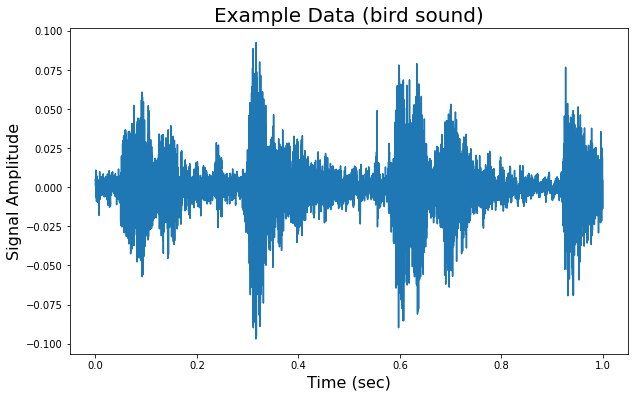

In [24]:
# 새 울음소리 1초 데이터 시각화
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title('Example Data (bird sound)', fontsize=20)
plt.xlabel('Time (sec)', fontsize=16)
plt.ylabel('Signal Amplitude', fontsize=16)
plt.show()

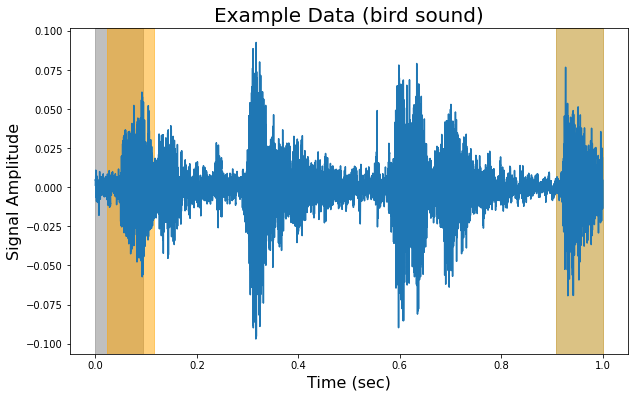

In [27]:
# 각 구간의 Frame 추출 시각화 (첫 번째, 두 번째, 마지막 Frame)
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title('Example Data (bird sound)', fontsize=20)
plt.xlabel('Time (sec)', fontsize=16)
plt.ylabel('Signal Amplitude', fontsize=16)

# 첫 번째 Frame (0~2048)
plt.axvspan(
    xmin=0, xmax=2048 / example_sr, color='gray', alpha=0.5
)

# 두 번째 Frame (512~2560)
plt.axvspan(
    xmin=512 / example_sr, xmax=(2048 + 512) / example_sr,
    color='orange', alpha=0.5
)

# 마지막 Frame (마지막 2048개 구간)
plt.axvspan(
    xmin=(example_sr - 2048) / example_sr, xmax=example_sr / example_sr,
    color='darkgoldenrod', alpha=0.5
)
plt.show()